In [113]:
#======汽车价格预测 （预测满有意思的，可以用来预测疾病，预防预测，市场预测之类的，和算卦差不多，好好学吧）===
#====需求：跟据已有汽车价格数据集，建立回归模型，分析以后的汽车价格，测试这个模型=====
#数据处理分析库
import numpy as np
import pandas as pd
from pandas import datetime

from pylab import mpl#【引入支持中文标签的包】
mpl.rcParams['font.sans-serif'] = ['SimHei']#【支持中文处理】

#画图库
from matplotlib import pyplot as plt
import seaborn as sns#是matplotlib的封装，更批量化的使用
import missingno as msno
#【安装方法：打开集成环境中的 anaconda Prompt，命令函数工具，可以用pip install missingno安装库，提示pip需升级，按照提示升级再安装即可，安装好后，conda list看下，已经有了，成功】
%matplotlib inline
#%matplotlib inline 意为可以在junpyter编译器里直接使用，功能是可以内嵌绘图，并且可以省略掉plt.show()这一步。其它编辑器可注掉

#数据分布统计库
from statsmodels.distributions.empirical_distribution import ECDF
#===ECDF:经验累计分布函数===
#对于每个观测值，一个经验累计分布函数（empirical cumulative distribution function，ECDF）==显示小于该值的点的百分比==
from sklearn.metrics import mean_squared_error, r2_score

#机器学习库#安装 pip install sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, LassoCV
#选模型模板
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
#?
seed=123


In [114]:

dataFrm = pd.read_csv('Auto-Data.csv',na_values='?')#na_values把空值?替换为NaN
#dataFrm.columns#看类别属性（列名）
#dataFrm.dtypes#看值续指标（类型）
#print("共：",dataFrm.shape)#共： (205, 26)
dataFrm.head()#看下前五列
#dataFrm.describe()#查看数据统计，每列个数，平均值，最小值最大值等。只统计数值形数据


,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0
1,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0
2,1,NaN,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0
3,2,164.0,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0
4,2,164.0,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0


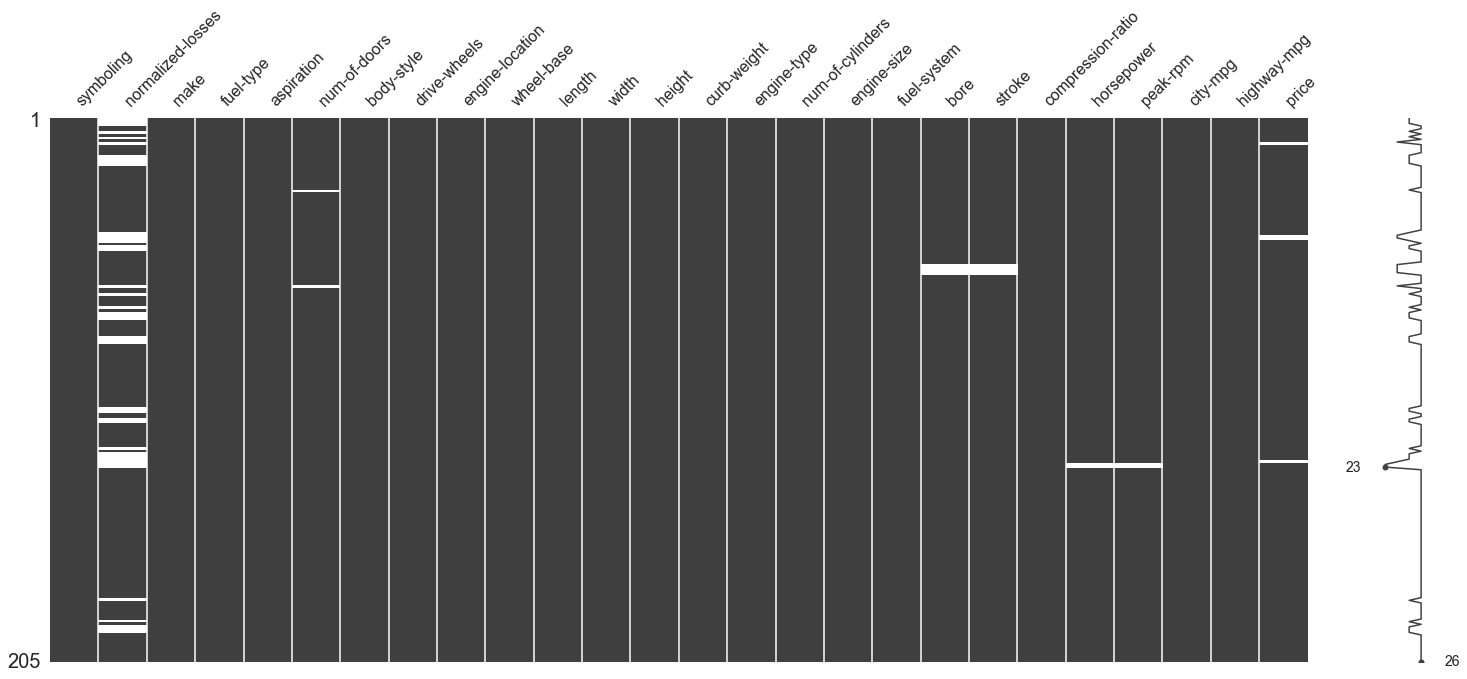

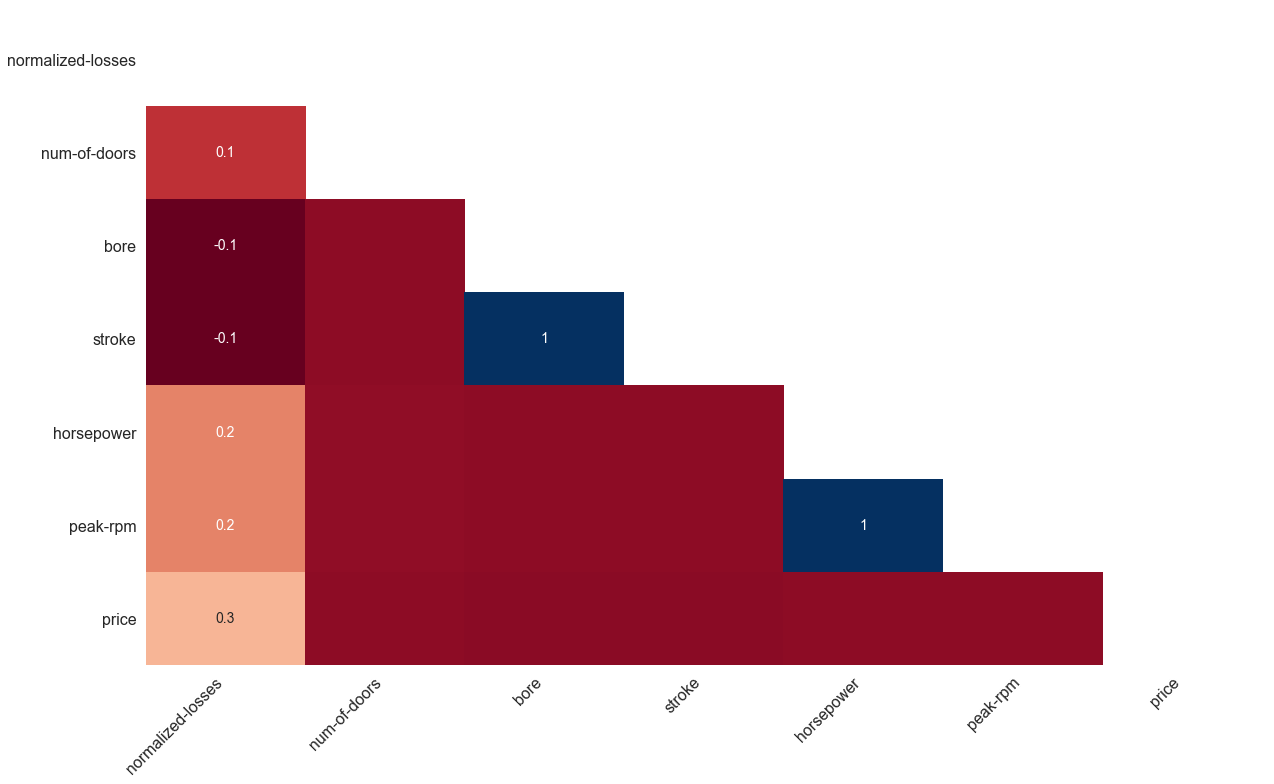

In [115]:
#==【经查看数据集比较小，缺失值比较多，所以，
#第一步：要先处理缺失值】===
sns.set(style="ticks")#?这步干嘛的？？？？？？？？？待看
#用seaborn库，返回头部引seaborn
#seaborn 是matplotlib的封装，更批量化的使用
msno.matrix(dataFrm)
#msno.matrix(dataFrm.sample(10))#也可用.sample()选多少个样本查看
#用missongno库，直接的看下，哪里缺失了，
#msno.bar(dataFrm) #柱形显示缺失分布
msno.heatmap(dataFrm)#热图相关性展示：一个变量的存在或不存在如何强烈影响的另一个的存在：缺失相关性大的列之间有关联，可知与normalized-losses相关度最高的是price 0.3
#msno.dendrogram(dataFrm)#===，相关性和缺失性综合看，左右看相关性越高的列越聚集，上下看，缺失越多的离0值越远，反之不缺的都贴近0。===
#更多使用见https://github.com/ResidentMario/missingno https://blog.csdn.net/Andy_shenzl/article/details/81633356
#【分析缺失值：遵循三条原则：
#白条是缺失，有的只有一行两行，那一条可去掉；
#白条较多的列normalized-losses，看看其它列都有值，这个就要重点补缺，可以分组，补组内的平均数（所有数的平均数），中位数（中间大小的数），众数（出现最从的那个数）；
#还一种方法就是只用不缺的部分统计，缺失的部分只用来测试。
#】


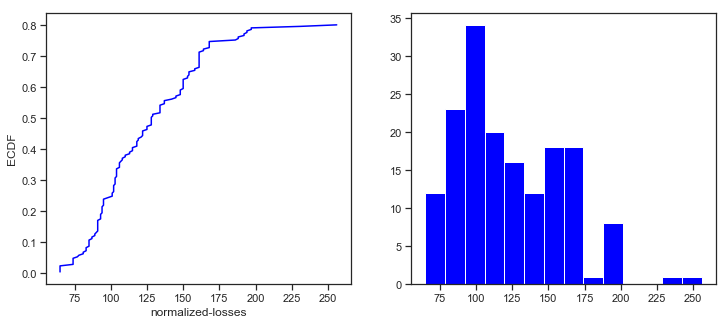

In [116]:
#【处理方法思路：用pd.isnull 取缺失值bool index传回，得到空值样本进行处理,如下这样取出】
#dataFrm[pd.isnull(dataFrm['normalized-losses'])].head()
#把空normalized-losses字段的空值过滤出来看看
#【分析缺失列数据特征：找合适的填充数】
sns.set(style='ticks')#???这个放这什么用途？？待看
plt.figure(figsize=(12,5))
c='blue'

#===ECDF:经验实验累计分布函数（看观测值大小的分布百分比）===
plt.subplot(1,2,1)#子图参数中间逗号可省
cdf = ECDF(dataFrm['normalized-losses'])#将要处理缺失值的列用大小分布百分比函数再处理再画出来
plt.plot(cdf.x, cdf.y, label = 'statmodels',color=c)
plt.xlabel('normalized-losses'); plt.ylabel('ECDF')#两行写一行时用分号隔开
#对于每个观测值，一个经验累计分布函数（empirical cumulative distribution function，ECDF）==显示小于该值的点的百分比==
#==整体数据区间分布==
plt.subplot(1,2,2)#子图参数中间逗号可省
#画区间图
plt.hist(dataFrm['normalized-losses'].dropna(),
        bins = int(np.sqrt(len(dataFrm['normalized-losses']))),
        color=c);#bins缩放是列长度开方,第一参要过滤掉空值dropna，看已有值的情况，且，空值做第一参会报错

#==从下图可知：80%的数据都低于200，且大部分低于125
#问题？ECDF和hist作用有什么不一样==


In [120]:
#【由上面两图展示可知，数据分布不规律，整体用平均数填充不合适，
#所以，解决方案是将数据分组，填充组内平均数】
#==分组准备：看下跟这列有关的数据指标
dataFrm.groupby('symboling')['normalized-losses'].describe()
#上面是以symboling分组查看分类项（列）normalized-losses的各项指标（行值）统计



,count,mean,std,min,25%,50%,75%,max
symboling,,,,,,,,
-2,3.0,103.000000,0.000000,103.0,103.0,103.000000,103.000000,103.0
-1,22.0,85.600000,17.624118,65.0,74.0,87.800000,95.000000,137.0
0,63.0,113.166667,28.306122,77.0,91.0,110.000000,114.083333,192.0
1,51.0,128.152174,27.174229,74.0,110.0,128.000000,148.000000,231.0
2,31.0,125.689655,29.144586,83.0,99.0,125.689655,137.000000,192.0
3,23.0,174.384615,24.494041,142.0,153.0,174.384615,180.192308,256.0


In [121]:
#【由指标图分析可知：按symboling分组的数据在组内相对差距不大，
# 所以，确定填充方案：对normalized-losses这列，先按symboling分组，填充组内平均数即可。
#其它缺失少的列按上面matrix白条图先drop掉】

#===去除缺失少的列中空值===
dataFrm = dataFrm.dropna(subset=['num-of-doors','bore','stroke','horsepower','peak-rpm','price'])
#===处理缺失多的列===
dataFrm['normalized-losses']=dataFrm.groupby('symboling')['normalized-losses'].transform(lambda x: x.fillna(x.mean()))
#==上面lambda x: 相当于生成一个简单函数，x为参数，相当于this,即前面的分组后的数对象，x.fillna()填充空，用x.mean()前面分组对象的均值。
#最后结果返回覆盖原列，空值即被替换掉了。==
print("空值处理后，共：",dataFrm.shape)
dataFrm.head()

#==空值处理完成==

空值处理后，共： (193, 26)


,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,174.384615,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0
1,3,174.384615,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0
2,1,128.152174,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0
3,2,164.000000,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0
4,2,164.000000,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0


In [122]:
#【第二步：进一步整理重组数据。
#步骤：查看特征（列与列之间）相关性，排序，
#分析相关度高的，有的是重复项可以去掉，
#有的是有换算关系，比如长宽高，可以用体积，用一个指标替换掉原来的三个】
cormatrix = dataFrm.corr(); #把处理完缺失的数据生成相关系数（相关度，列列两两相关，故出现一半相关的，只需取上三角或下三角用于进一步分析处理）矩阵
#cormatrix#查看发现上三角下三角数据相同，只一半即可。对角线是1，自己和自己列的相关度是最高1。
cormatrix *= np.tri(*cormatrix.values.shape, k=-1).T
#print(*cormatrix.values.shape)#(16,16) 加* 返回行列数字16,16上面参数替换成16,16也可以
#返回函数的上三角矩阵，k=-1 把对角线上的置0，忽略不记。
#还可传第三参dtype=int，默认是float
#.T去掉了上三角，转置下，把下三角移上面去，方便看
#===*=即，cormatrix = cormatrix *np.tri()..
#为什么用cormatrix自身再*一下，因为后面的取上三角是取到的上三角都1，下三角都2的一个矩阵
#所以用自身再乘一下，*0 = 0， *1还=自身，就得到了自身的上三角矩阵了。
#同理可以得到上三角*10，10倍的矩阵，只需在后面*10就行了，就是这个道理===
cormatrix

,symboling,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
symboling,0.0,0.593658,-0.536516,-0.363194,-0.247741,-0.517803,-0.231086,-0.068327,-0.144785,-0.010884,-0.175160,0.069491,0.227899,0.017639,0.085775,-0.084835
normalized-losses,0.0,0.000000,-0.167286,-0.038857,0.034178,-0.445925,0.085758,0.152544,0.032765,0.057834,-0.149620,0.277376,0.245497,-0.245313,-0.189911,0.160602
wheel-base,-0.0,-0.000000,0.000000,0.879307,0.818465,0.591239,0.782173,0.568375,0.495957,0.174225,0.252234,0.377040,-0.350823,-0.504499,-0.571771,0.584951
length,-0.0,-0.000000,0.000000,0.000000,0.857368,0.491050,0.882694,0.686998,0.606373,0.121888,0.156061,0.589650,-0.276144,-0.702143,-0.731264,0.695928
width,-0.0,0.000000,0.000000,0.000000,0.000000,0.310640,0.867640,0.739903,0.541633,0.188733,0.188631,0.621532,-0.247612,-0.657153,-0.702009,0.754649
height,-0.0,-0.000000,0.000000,0.000000,0.000000,0.000000,0.305837,0.026906,0.182445,-0.054338,0.253934,-0.081730,-0.257334,-0.111166,-0.159850,0.136234
curb-weight,-0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.857188,0.645070,0.175349,0.161030,0.762154,-0.278528,-0.777763,-0.818104,0.835368
engine-size,-0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.581854,0.214518,0.025257,0.845325,-0.217769,-0.716378,-0.737531,0.888778
bore,-0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.065038,-0.004172,0.572972,-0.273766,-0.601369,-0.608804,0.546295
stroke,-0.0,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.199600,0.102913,-0.068420,-0.031248,-0.040274,0.096007


In [123]:
cormatrix = cormatrix.stack()#用另一种形式看下各列相对别列的指标
cormatrix



symboling          symboling            0.000000
                   normalized-losses    0.593658
                   wheel-base          -0.536516
                   length              -0.363194
                   width               -0.247741
                   height              -0.517803
                   curb-weight         -0.231086
                   engine-size         -0.068327
                   bore                -0.144785
                   stroke              -0.010884
                   compression-ratio   -0.175160
                   horsepower           0.069491
                   peak-rpm             0.227899
                   city-mpg             0.017639
                   highway-mpg          0.085775
                   price               -0.084835
normalized-losses  symboling            0.000000
                   normalized-losses    0.000000
                   wheel-base          -0.167286
                   length              -0.038857
                   w

In [124]:
#==排下序===
cormatrix = cormatrix.reindex(cormatrix.abs().sort_values(ascending=False).index).reset_index()
cormatrix.columns = ["v1","v2","relation"]#加新分类（列）名，替换默认的
cormatrix.head(10)
#.abs() python取数字绝对值，去掉负号，把新排序的index传回矩阵reindex，替换，再加一列新索引reset_index()


,v1,v2,relation
0,city-mpg,highway-mpg,0.971975
1,engine-size,price,0.888778
2,length,curb-weight,0.882694
3,wheel-base,length,0.879307
4,width,curb-weight,0.867640
5,length,width,0.857368
6,curb-weight,engine-size,0.857188
7,engine-size,horsepower,0.845325
8,curb-weight,price,0.835368
9,horsepower,city-mpg,-0.833615


In [125]:
#【根据相关度分析数据：
#0.97最高的两列，名字关不多，可以去掉一个,相关度高的都可以去掉一个问题不大，但price这样的关键字段小心删；
#在下面，长宽高 成比例，可以合成一个新的体积替换 ，
#==注意：上面分析过程都是用的cormatrix这个对象，我们给我们的dataFrm做出来的矩阵，中间对象，只用于查看分析数据相关性，并没有打乱原有的dataFrm，
#和之前补缺失不同，那个是数据本身要补，所以都操作的dataFrm对象。
#我们现在要做的是组合新列替换旧列，所以也是要直接哲作在dataFrm对象上】==
dataFrm['volume'] = dataFrm.length*dataFrm.width*dataFrm.height#整合长宽高列
dataFrm.drop(['width','height','length','curb-weight','city-mpg'],axis=1,inplace=True)# axis=1是列操作，
#curb-weight指标用体积也能代表，且与长宽高关系也很大，所以可以省掉
dataFrm.columns


Index(['symboling', 'normalized-losses', 'make', 'fuel-type', 'aspiration',
       'num-of-doors', 'body-style', 'drive-wheels', 'engine-location',
       'wheel-base', 'engine-type', 'num-of-cylinders', 'engine-size',
       'fuel-system', 'bore', 'stroke', 'compression-ratio', 'horsepower',
       'peak-rpm', 'highway-mpg', 'price', 'volume'],
      dtype='object')

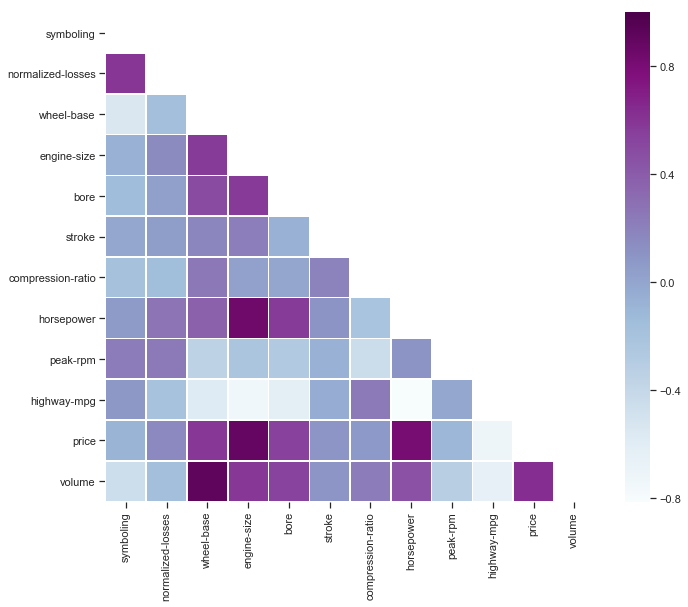

In [126]:
#整合完数据以后，再来看下相关度，这次，换种方式，也可以直接画图直观看下
corr_all = dataFrm.corr()#生成相关度矩阵
mask = np.zeros_like(corr_all,dtype = np.bool)
#创建蒙板：np.zeros_like生成一个全0矩阵，结构同corr_all， 值类型为布尔np.bool
#mask#这一步打印看，全是False
mask[np.triu_indices_from(mask)] = True
#np.triu_indices_from 返回矩阵上三角的索引，置为真。indices是index的复数
#print(mask)#打印可得一个上三角真，下三角为假的矩阵，做下面画关系图的蒙板，相当于像上面一样和cor_all相乘，过滤掉下三角

#开始画图，用seaborn的热度图
f,ax1 = plt.subplots(figsize = (11,9))
sns.heatmap(corr_all, mask = mask, 
            square = True, linewidths = .5, ax=ax1, cmap = 'BuPu')
#参数：矩阵数据，蒙般，格子宽度，ax？cmap设置调色盘，颜色，后面加s，或其它设置好的调色板,annot =True显示数字，square = True正方形，
#cbar=False不显示色带，bar_kws = ['orientaion':'horizaintal'], #是否横向显示图例色带
#，逗号的地方可以折行换行
#mask蒙板，有点和photoshop一样啊。知识都相通的，知道的越多学的就越容易。
#===终于知道ax是干嘛的了，ax 画的是哪个子图，如下，还可以画一个，上面要指它两个ax1,ax2，后面加nrows=2===
#f,(ax1,ax2) = plt.subplots(figsize = (20,12),nrows=2)
#sns.heatmap(corr_all, mask = mask,square = True, linewidths = .5, ax=ax2, cmap = 'Reds')

plt.show()



G:\Users\Administrator\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


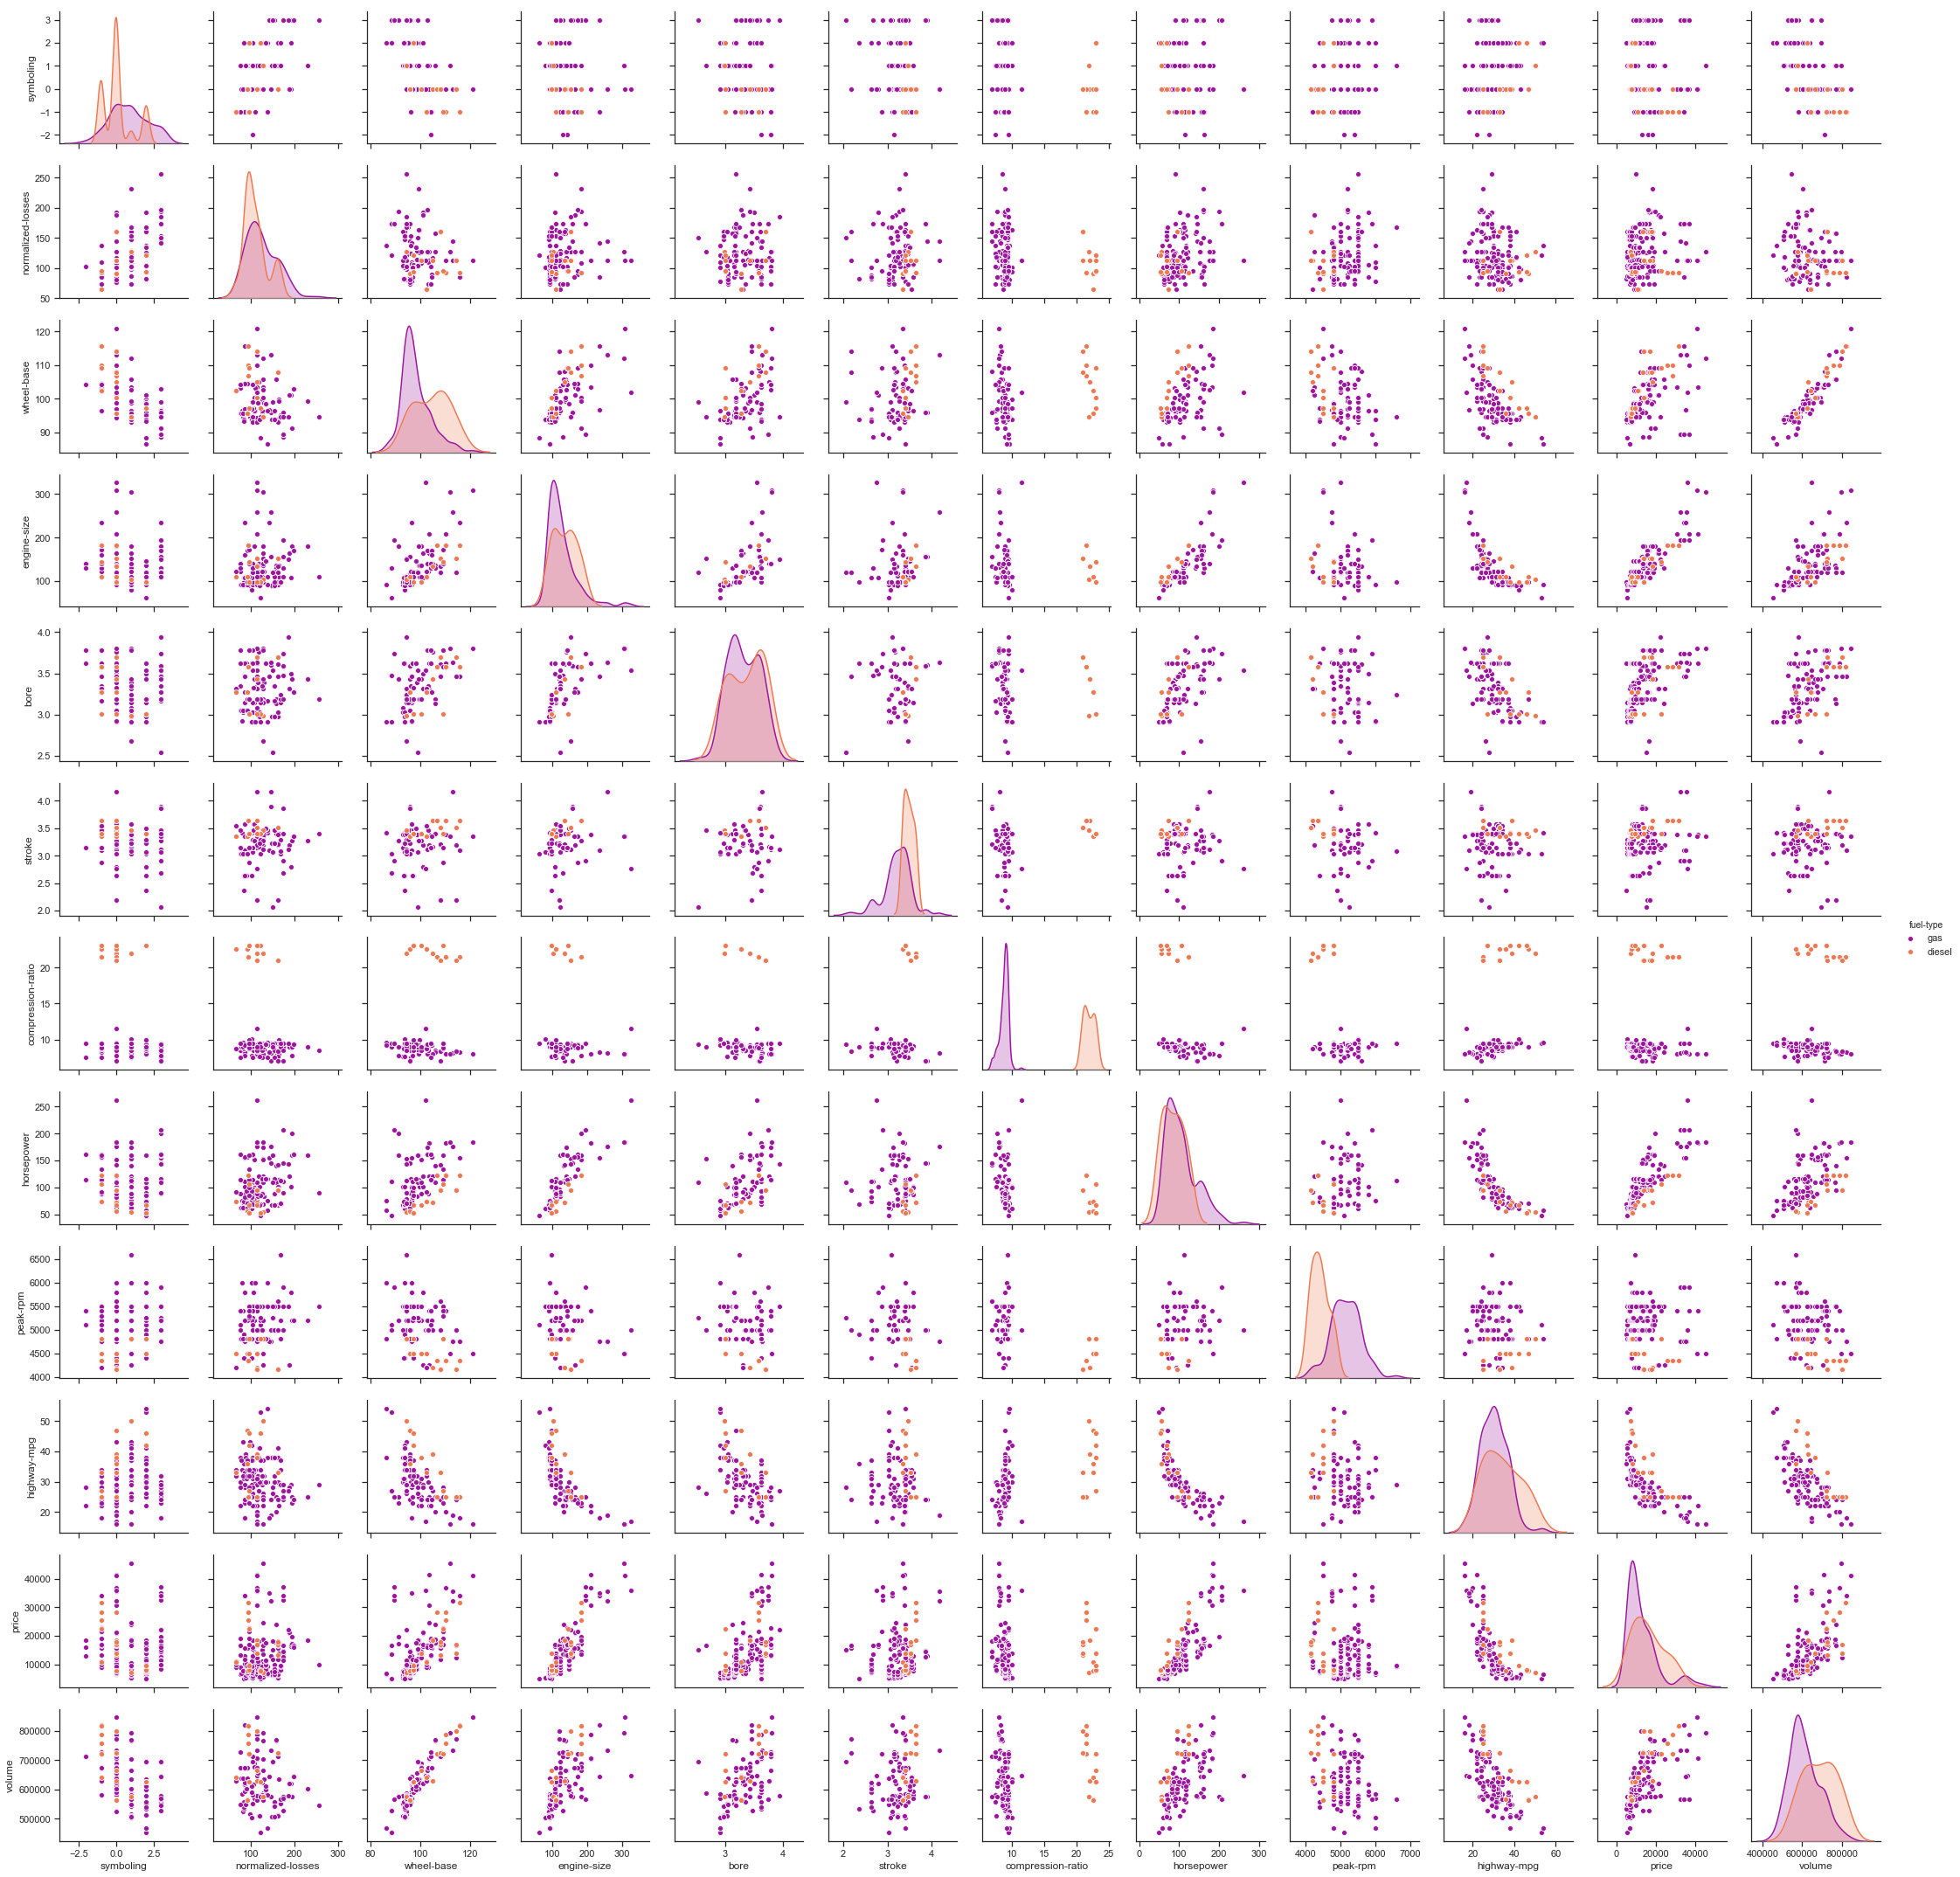

In [127]:
#【分析数据：由上图可看出，price我们要预测的价格，和这几列关系比较大：wheel-base,engine-size, bore,horsepower.】
#==画另一种类型的图 pairplot 多变量散点图
sns.pairplot(dataFrm, hue='fuel-type',palette='plasma')
#hue 指定查看变量,列，指标，fuel-type是燃油，烧油还是烧气，之类的，比对看下
#palette调色板




G:\Users\Administrator\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


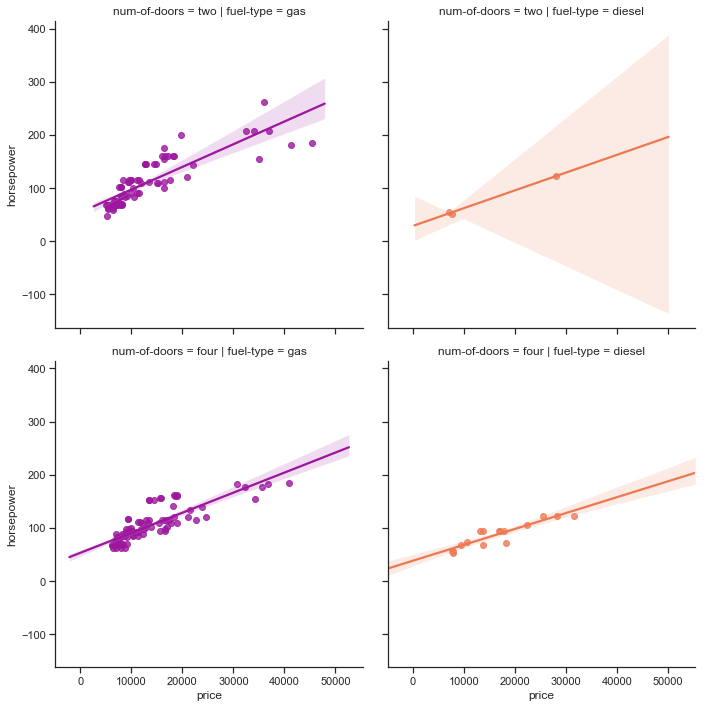

In [128]:
#==上面是从整体上看一个指定分类的值分布情况==
#==【下面看具体的，价格与马力之间的关系，用lmplot,可以用来做回归模型（让散点变量接近于中间那条斜线为目的），此处只是查看下，看看怎么用，可看出这些指标比较稳定，都在线周围，加fuel-type，num-of-doors，多变量混合查看】==
sns.lmplot('price','horsepower',dataFrm, 
           hue = 'fuel-type', col='fuel-type', row='num-of-doors',
           palette='plasma',
           fit_reg=True);
#hue 表示指定散点变量
#row指定子表水平分类从左到右排，是doors，依次是2门，4门，
#col指定纵向分类分别从上到下这样走，依次介gas，dissel
#指标太多，可以注掉几个，分别看
#fit_reg = True 分析并绘制回归模型，即，画回归线，带中间那条线的
#相关使用https://blog.csdn.net/suzyu12345/article/details/69029106
#其它seaborn相关函数https://blog.csdn.net/jack_ricky/article/details/79578895



In [148]:
#【由图分析可知：点偏离不大，在线的附近。可以理解为，变量燃油类型无论是烧油还是烧气，都是符合这个价格与马力的成比例关系】

#【第三步：预处理样本数据。上面做了空值处理。重组了分类。分析了数据特性。
#可知如果有比如偏大或偏小的数会影响结果，而且数据分散不好分析，预算理就是要做一个标准化的数据组，对连续值进行标准化，去掉那些特殊的。
#目标（和下面一条矛盾了）？原始值不以0为均值，而且它的偏离值都落在0的中心附近，像上面回归图中那样
#对数据进行标准化处理就是 将其转化为===均值为0，方差为1的正态分布(不标准化，分布是分散的)，====
#这一步是由函数自动完成的。 参考：https://blog.csdn.net/u010758410/article/details/78158781
#https://blog.csdn.net/weixin_39175124/article/details/79463993】
#让浮动范围变小在0附近

#====对连续值进行标准化===
#【定义目标值和选定特征（用于训练模型）】
#以价格作为目标值，看其它特征变化，训练模型。所以下面要把price从统计特征中去掉
target = dataFrm.price

#regressor 回归量
regressors = [x for x in dataFrm.columns if x not in ['price']]

#取dataFrm的列，不含price，返回一个列表
#print([x for x in dataFrm.columns])
#print(dataFrm.columns)
#print(regressors)

#创建一个过波掉price的数据集series
features = dataFrm.loc[:, regressors]#:所有值，逗号后面是过滤条件。可写成[:][regressors]
#print(features.shape)
#print(dataFrm.loc[:].shape)
#print(features)

#先把数据拿出来
#取连续值列名（连续变化的数值型列），用于取特征值进行标准化 #
num = ['symboling', 'normalized-losses', 'volume', 'horsepower', 'wheel-base','bore', 'stroke','compression-ratio', 'peak-rpm','engine-size']

#【标准化数据（变成正态分布），用sklearn.preprocessing 的StandardScaler的fit_transform】，
#头部引sklearn相关的
standard_scaler = StandardScaler()
#standard_scaler.fit_transform(features[num])#注意，写错了，===***标准化以后返回处理的处理的数据集，替换原来的列***===
features[num] = standard_scaler.fit_transform(features[num])#【标准化的列，只是上面传入的要标准化的连续性指标列】

#查看标准化后的部分数据
features.head()#标准化的不是原始的dataFrm，是从中取出来的一些特征，有进行了标准化处理的。所以要看后处理的这个数据集features
#【查看可知，标准化处理后的值和原来不一样了，都变成了，在1到-1之间的小的数，均值为0，方差为1的正态分布/高斯分布。】
#==engine-size为什么没有标准化？待查，可能不是连续性数据。对结果影响不大？可能忘记了，回头加上了看看结果有什么不同，==
#【其它列也在，只是标准化的列标准化过后替换了原来的】


,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,num-of-cylinders,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,highway-mpg,volume
0,1.78685,1.477685,alfa-romero,gas,std,two,convertible,rwd,front,-1.682379,...,four,0.045215,mpfi,0.513027,-1.808186,-0.288273,0.198569,-0.213359,27,-1.168294
1,1.78685,1.477685,alfa-romero,gas,std,two,convertible,rwd,front,-1.682379,...,four,0.045215,mpfi,0.513027,-1.808186,-0.288273,0.198569,-0.213359,27,-1.168294
2,0.16397,0.144710,alfa-romero,gas,std,two,hatchback,rwd,front,-0.720911,...,six,0.575559,mpfi,-2.394827,0.702918,-0.288273,1.334283,-0.213359,26,-0.422041
3,0.97541,1.178276,audi,gas,std,four,sedan,fwd,front,0.142781,...,four,-0.461021,mpfi,-0.517605,0.480415,-0.036204,-0.039139,0.856208,30,0.169527
4,0.97541,1.178276,audi,gas,std,four,sedan,4wd,front,0.077596,...,five,0.189854,mpfi,-0.517605,0.480415,-0.540341,0.304217,0.856208,22,0.193551


In [149]:
#【第三步-2：预处理-对非数字字符串值(分类属性，比如男女，转化为0，1)编码，让计算机认识。用one-hot】
#取非数值的分类变量，列
#===one-hot编码能处理非连续型数值特征，比如性别，用one-hot处理后就变成男女两个特征。===
#将离散特征的取值扩展到了欧式空间，离散特征的某个取值就对应欧式空间的某个点，在回归，分类，聚类等机器学习算法中，特征之间距离的计算或相似度的计算是非常重要的，而我们常用的距离或相似度的计算都是在欧式空间的相似度计算，计算余弦相似性，基于的就是欧式空间
#它是根据你的数据描述的特征统计的，或自己的以往经验库，统计方法是暗箱的，函数自动完成。
#方法：我们用 pandas 自带的get_dummies函数即可 dummy样本，傀儡

#print(features.shape)#先看看未处理前（193，21）

#需要处理的非数值列（要进行one-hot编码的）取出，
classes = ['make', 'fuel-type', 'aspiration', 'num-of-doors', 'body-style', 'drive-wheels', 'engine-location','engine-type', 'num-of-cylinders', 'fuel-system']

#使用pd.get_dummies自动完成非连续性字符离散特征到one-hot数值编码的转换
dummies = pd.get_dummies(features[classes])
#print(dummies)#可见到生成的是一些新列，用拆份的特征代替，有新的列名。
#替换到原来的旧列
features = features.join(dummies).drop(classes,axis=1)
#join两个dataFrame相连，drop删除列

print("one-hot编码后共：",features.shape)
features.head()#之前的21列，现66列，增加了45列，说明一个大特征分成了很多打散的数字代表的小特征



one-hot编码后共： (193, 66)


,symboling,normalized-losses,wheel-base,engine-size,bore,stroke,compression-ratio,horsepower,peak-rpm,highway-mpg,...,num-of-cylinders_six,num-of-cylinders_three,num-of-cylinders_twelve,fuel-system_1bbl,fuel-system_2bbl,fuel-system_idi,fuel-system_mfi,fuel-system_mpfi,fuel-system_spdi,fuel-system_spfi
0,1.78685,1.477685,-1.682379,0.045215,0.513027,-1.808186,-0.288273,0.198569,-0.213359,27,...,0,0,0,0,0,0,0,1,0,0
1,1.78685,1.477685,-1.682379,0.045215,0.513027,-1.808186,-0.288273,0.198569,-0.213359,27,...,0,0,0,0,0,0,0,1,0,0
2,0.16397,0.144710,-0.720911,0.575559,-2.394827,0.702918,-0.288273,1.334283,-0.213359,26,...,1,0,0,0,0,0,0,1,0,0
3,0.97541,1.178276,0.142781,-0.461021,-0.517605,0.480415,-0.036204,-0.039139,0.856208,30,...,0,0,0,0,0,0,0,1,0,0
4,0.97541,1.178276,0.077596,0.189854,-0.517605,0.480415,-0.540341,0.304217,0.856208,22,...,0,0,0,0,0,0,0,1,0,0


In [159]:
#【第四步：下面开始回归了：事先准备训练模型，划分训练和测试特征数据集，确定目标值样本标签。】
#【划分数据集，用train_test_split】#参考（很好的使用说明）：http://www.cnblogs.com/bonelee/p/8036024.html
#==分割数据到训练模型和测试模型==
X_train, X_test, y_train, y_test = train_test_split(features, target,
                                                   test_size=0.2,
                                                   random_state=seed)
#参数：样本特征数据集；样本标签（要求的目标值）；样本比例(训练和测试的比例，用整数代表占多少个）；阴机种子在开头定义了，一样的随机种子产生的随机数一样，用于需重复试验的情况
print("训练数据集X：",X_train.shape,"测试集X：",X_test.shape)#135+58=193上面总数，58/138测试占0.3
#print("训练数据集y：",y_train.shape,"测试集y：",y_test.shape)# (135,)(58,) X，y合体为features一个参数传进去了，这里只看上面一个就好
#【改动了上面测试集变少，最后预测的值更准确了。有意思】

训练数据集X： (154, 66) 测试集X： (39, 66)


In [160]:
#【第五步：线性回归求解（一步一步修改变量，回归到目标值，训练机器学习） 
#Lasso回归:损失函数后面加一个alphas绝以值项 惩罚最大值（去掉一个最高分，保留更规律的数据集）】
#参考实例：https://blog.csdn.net/xiaozhu_1024/article/details/80585151
#https://blog.csdn.net/daunxx/article/details/51596877
#***有用：https://blog.csdn.net/hzw19920329/article/details/77200475***

#其中λ（alpha）称为正则化参数，如果λ选取过大，会把所有参数θ均最小化，造成欠拟合，如果λ选取过小，会导致对过拟合问题解决不当，因此λ的选取是一个技术活。

#===大致思路：定义alpha（调合参数项，与θ共同中合作用？）,遍历不同的alpha进行训练和得分===
#lasso.fit() 基于训练数据 fit适合，调整
#lasso.score() 预测性能得分

#开始==头部引 sklearn 的linear_model(线性模型) 的Lasso LassoCV 

#定义alphas （对数级变化）
alphas = 2. **np.arange(2,12)#两个**是次方（幂）
#alphas=[[1.,2.,3.],[4.,5.,6.]]
scores = np.empty_like(alphas)
#===此处生成一个与alphas相同结构、元素类型相同的随机矩阵，用于存放每一个alphas变化得到的性能得分。所以有几个alphas就有几个列表元素
#也可以定义一个空列表 scores = [],结果依次append进来也是一样的。上面这种方法可常用，应用到其它场景。===
#print(alphas)
#print(scores)

#===遍历alphas 训练fit（传入上面train_test_split划分的trian部分） ,预测性能得分.score（传入上面train_test_split划分的test部分）并存入scores列表===
for i, a in enumerate(alphas):#开始建模，建Lasso模型
    lasso = Lasso(random_state = seed)#设置随机种子
    lasso.set_params(alpha = a)#设置惩罚项
    lasso.fit(X_train, y_train)#训练,==训练集是建立这个方程===
    scores[i] = lasso.score(X_test, y_test)#取值 求结果，最终结果集由测试集计算的，测试集是来利用这个方程进行结果的评估	

#【上面第一种方法只是举这样一个例子。一般情况下，测试集是不用来选参数的。我们可以用眼睛看到最高点，但一般不用这种方法，而是下面的另一种方法LassoCV】


In [161]:
#=================
#===【第五步 .2：lassoCV回归 交叉验证 Cross Validation 可自动找到最佳alpha值（回归方法同Lasso，区别在验证方法，可自动找到合适的alpha，而不用自定义alpha再画图用肉眼找最高点了）
#方法：把数据平均分成几份，几份用来训练，剩下的做验证】===

#LassoCV类的损失函数和损失函数的优化方法完全与Lasso类相同，区别在于验证方法。
#LassoCV类对超参数α使用了交叉验证，来帮忙我们选择一个合适的α。
#免去了我们自己去一轮轮筛选α的苦恼。　
#LassoCV类是进行Lasso回归的首选。当我们面临在一堆高位特征中找出主要特征时，LassoCV类更是必选。当面对稀疏线性关系时，LassoCV也很好用。

#==大致思路：lassoCV(CV = 10 分10份，指定随机种子seed)；
#.fit(featrues,target)；训练
#.score(featrues,target)；拿到性能得分
#.alpha_拿alphas惩罚项值

#和上面一样，alpha是x轴，在它不同的情况下，预测值，性能得分也不同。
#画图找最高点，即是最好的参数，梯度上升反过来，梯度下降，达到最优的那个值。

lassocv = LassoCV(cv = 10, random_state = seed)#数据分10份（比如9份训练，1份测试效果），指定随机种子
lassocv.fit(features, target)#fit 训练 
lassocv_score = lassocv.score(features, target)#取值，拿性能得分
lassocv_alpha = lassocv.alpha_#【取最优alpha，取出来并未使用，不知道干嘛用的？待查】



CV结果： 0.9355975969864421 45.35999814958527


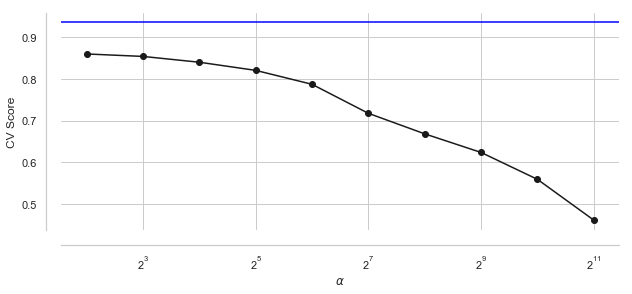

In [162]:

#===上面两种方法画图展示 横线是LassoCV 曲线变化是Lasso==
sns.set_style("whitegrid")#ticks车票装背景，不过加了下面的despine就会去掉上右
plt.figure(figsize = (10,4))
plt.plot(alphas,scores, '-ko')#第三参颜色,Red比如
plt.axhline(lassocv_score, color = c)
plt.xlabel(r'$\alpha$')#输出alpha字母
plt.ylabel('CV Score')
plt.xscale('log',basex =2)#x轴的变化 以2的对数级变化
sns.despine(offset = 15)#去掉上右边，offset设置与轴的距离margin

print('CV结果：', lassocv_score, lassocv_alpha)
#由结果可知lassocv和lasso合适的alpha大致一样。都是最高点0.83左右（与答案0.82有些误差，回头看下engine-size加上会怎么样？）。
#更多lassoCV解释见https://www.cnblogs.com/pinard/p/6026343.html

#补充：上面惩罚项alphas=0那就是最小二乘了



Lasso 选取了26 个特征，过滤掉了其它40个特征。


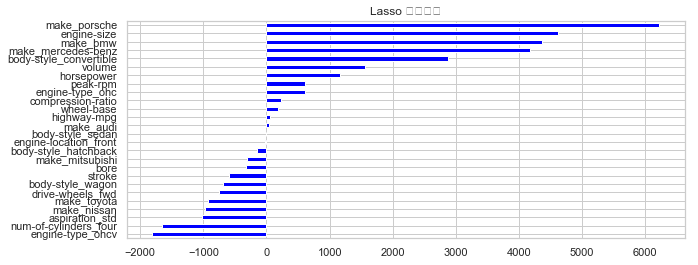

In [163]:
#【遗留问题1：注：上面因为加了engine-size，值高了，为什么CV高了，Lasso没高？差不太多】【为什么engine-size不加？不是连续性的？】
#【从上图中看，我们得到了一个很好的R^2 分数0.83...很高。】
#【还可以看看什么？还可以看看哪些个特征 对我的结果产生了什么样的影响，正影响还是负影响，找出最好的alpha,用来建模】
#【方法：Series()把所有系数因子都拿出来，看哪些是重要的值比较大的】
#【然后把最后得到的那个最好的alpha拿来建模（用这个最好的alpha重新再次LassoCV）】
#参考：【较好】https://www.sohu.com/a/206467766_654419

#lassocv 回归系数
coefs = pd.Series(lassocv.coef_,index=features.columns)
#抽取lassocv系数序列数据集，抽取features特征列有关的(index = 控制取哪几列的) 
#print(coefs)
print("Lasso 选取了"+str(sum(coefs!=0))+" 个特征，过滤掉了其它"+str(sum(coefs==0)) +"个特征。")
#Lasso 选取了26 个特征，过滤掉了其它40个特征。之前是选了6个特征。后加上engine-size变26个特征，答案是13个。选的多可能更精确。先这样吧。

#选取前10个和后10个组合画柱形图
coefs = pd.concat([coefs.sort_values().head(13),coefs.sort_values().tail(13)])
#pd.concat，组合两组序列数据集，变新序列数据集

plt.figure(figsize = (10,4))
coefs.plot(kind='barh',color=c)#barh水平柱形，bar，垂直
plt.title("Lasso 模型系数")
plt.show()


In [164]:
#【第五步.3：拿到最好的alpha值（或直接用LassoCV自动选alphas，上面只是说了几种方法，这里是实际应用）后，
#用于建模，训练模型，取预测值。】
#（上面LassoCV 只是演示可以直接用features,target取最优alphas，此处是真正实操）

#print(alphas)#[   4.    8.   16.   32.   64.  128.  256.  512. 1024. 2048.]
#print(lassocv_alpha)#342.0081418966275
model_l1 = LassoCV(alphas = alphas,cv = 10, random_state = seed).fit(X_train, y_train)
#n_alphas=lassocv_alpha 沿参数调整方向的alphas？ #alphas = alphas alphas参数为一开始建模时设定的alphas 惩罚项列表，没有的话，默认。不过最后准确度不高，0.6
#【上面这里和上面一样，还是LassoCV,只需把之前定义的alphas列表传进去，它会自动找到最合适的alphas，前面找到那个alphas_，只是为了打印出来看下。或留作它用】
#【用最好的alphas值建模，大概就是n_alphas=lassocv_alpha，但效果并不好，只有0.6,准确度，所以此处还是用了自动选的方式，并没用到前面取的最好的alpha？待查】
y_pred_l1 = model_l1.predict(X_test)
#【预测，得到预测值，给下面模型中使用。】
#【为什么y的预测值要从X_test中取？
#***===预测值是预测的X_test，X是变量，是我们要预测的参数，y是我们要的结果，所以叫y_pred（y的预测值是由predict(X的测试参数)取到的），
#还是要从方差公式和损失函数那里的xy来理解===***】
#参考：http://www.cnblogs.com/sandy-t/p/6863918.html
model_l1.score(X_test, y_test)
#上面模型建好后，传入测试数据，取结果集
#【评估：此处我们预测的分数值和上面两种方法差不多，都是0.8多，说明可以应用到未来数据的预测。】

0.840242388962918

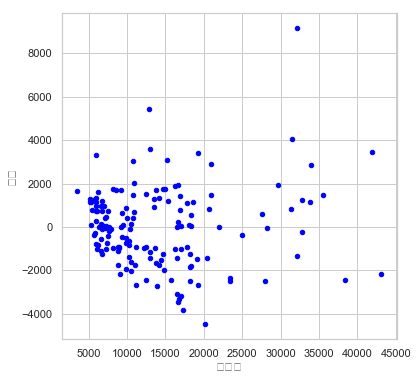

In [165]:
#【第六步：其它评估方法：
#还可以把残差点画出来，离散图，x预测值 ，y真实值，
#我们希望x,y之间的差异在0附近浮动是最好的。】
#【方法：用pd.dataframe把结果导进来，
#指定一个残差值，通过很多种方式都可以去衡量】

#==画残差图==
plt.rcParams['figure.figsize'] = (6.0, 6.0)
#指定图片象素

preds = pd.DataFrame({"预测值":model_l1.predict(X_train),"真值":y_train})
#pd.DataFrame()里面参数筛选条件是字典，当前结果集导进来，两参数分别是第一列第二列
preds["残差"] = preds["真值"]-preds['预测值']
#【预测训练值与真实值相减，看残差大不大，在0附近，模型就可以】
preds.plot(x="预测值",y="残差",kind ="scatter",color=c)

#【由图可知在0附近，说明真值和预测值相差不大，模型可通用】

In [166]:
#【第六步.2：评估指标：
#上面只是画图，只是感观，大概看一下。
#除了上面评估方法，我们最常用的两个评估指标是：MSE，R^2】
#上面比较完之后用公式表式可以得到MSE（均方误差，方差）, 或RMSE（前面开方） ；
#也可以得到R^2值，在0.83 接近1合格】
def MSE(y_true, y_pred):
    mse = mean_squared_error(y_true,y_pred)
    #均方误差（mean-square error, MSE）：估计量与被估计量之间差异程度
    print("MSE:%2.3f"%mse)
    return mse
def R2(y_true,y_pred):
    r2 = r2_score(y_true,y_pred)
    #R^2(确定系数)回归评分函数。最好的可能得分是1.0
    print('R2:%2.3f'%r2)
    return r2
#%2.3f 表示，小数点后保留3位，整数部分不足两位前面补0
MSE(y_test,y_pred_l1)
R2(y_test,y_pred_l1)

#一句话理解
#MSE = mean_squared_error(y_test,model_l1.predict(X_test))
#【fit的是X_train, y_train,评估取值是.scores X_test,y_test，这里算方差真实值y_test，取的测试真实样本，预测值是预测的X_test，X是变量，是我们要预测的参数，y是我们要的结果，还是要从方差公式和损失函数那里的xy来理解 】
#参考：http://www.cnblogs.com/sandy-t/p/6863918.html
#RMSE = np.sqrt(mean_squared_error(y_test,y_pred_l1))
#print("%2.3F"%MSE)


MSE:3916815.374
R2:0.840


0.840242388962918

In [167]:
#【第七步：最终使用预测，查看效果】
#==使用模型预测==
d = {"真实值":list(y_test),#用这些测试值测试你的预测是否准确。测试值是真实值拿出来做测试用的那部分。
    "预测值":pd.Series(y_pred_l1)#前边定义的LassoCV的predict()，也是一个遍历alpha列表得到的预测值序列list
    }
pd.DataFrame(d).head()
#pd.DataFrame参数是字典，数据过滤条件，两参数分别是第一列第二列

#================
#学习方法扩展：查API地址：sklearn官网，搜索linear_model, Lasso LassoCV 交叉验证和建模等，看API说明和实例
#其它类似本例参考【较好】https://www.sohu.com/a/206467766_654419
#https://www.cnblogs.com/itdyb/p/5845563.html
#https://blog.csdn.net/hzw19920329/article/details/77200475
#https://blog.csdn.net/SA14023053/article/details/51817249
#官方API
#https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html#sklearn.linear_model.LassoCV
#参考：http://www.cnblogs.com/sandy-t/p/6863918.html

,真实值,预测值
0,8499.0,8437.939151
1,17450.0,17454.114705
2,9279.0,9194.275681
3,7975.0,10449.191442
4,6692.0,6373.409050


In [ ]:
#【遗留问题1：注：上面因为加了engine-size，值高了，为什么CV高了，Lasso没高？差不太多】【为什么engine-size不加？不是连续性的？】
#【遗留问题2：model_l1 = LassoCV(alphas = alphas,cv = 10, random_state = seed).fit(X_train, y_train)
#n_alphas=lassocv_alpha 沿参数调整方向的alphas？这个是最佳的alphas值吗？ #alphas = alphas 之前定义的alphas列表，LassoCV可以自动找到最合适的？
#为什么最佳alpha值后面没用到？取它是作什么用的？】